In [6]:
%matplotlib notebook
import blaze as bz
import dateparser
import fiona
import geopandas
from gevent.pool import Pool
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import glob
import grequests
import pandas as pd
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.poolmanager import PoolManager
import ssl
import shapely

S:\programs\x64\Anaconda3\lib\site-packages\odo\backends\pandas.py:94: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))
S:\programs\x64\Anaconda3\lib\site-packages\blaze\server\server.py:17: ExtDeprecationWarning: Importing flask.ext.cors is deprecated, use flask_cors instead.
  from flask.ext.cors import cross_origin


In [2]:
def parse_date(date):
    if date and date != 'NA':
        return dateparser.parse(date).date()

In [3]:
str_fields = [
    'Defendant.Addr.ZIP.1',
    'Defendant.Addr.ZIP.2',
    'Defendant.Atty.Addr.2',
    'Defendant.Atty.Phone',
    'Defendant.Atty.ZIP.1',
    'Defendant.Atty.ZIP.2',
    'Defendant.Phone.Nbr',
    'Nature.of.Claim',
    'Next.Event.Desc',
    'Next.Hearing.Date',
    'Next.Hearing.Desc',
    'Plaintiff.Addr.ZIP.1',
    'Plaintiff.Addr.ZIP.2',
    'Plaintiff.Atty.Phone',
    'Plaintiff.Atty.ZIP.1',
    'Plaintiff.Atty.ZIP.2',
    'Plaintiff.Phone.Nbr',
    'Second.Defendant.Addr.ZIP.1',
    'Second.Defendant.Addr.ZIP.2',
    'Second.Defendant.Atty.Addr.1',
    'Second.Defendant.Atty.Addr.2',
    'Second.Defendant.Atty.City',
    'Second.Defendant.Atty.Name',
    'Second.Defendant.Atty.Phone',
    'Second.Defendant.Atty.State',
    'Second.Defendant.Atty.ZIP.1',
    'Second.Defendant.Atty.ZIP.2',
    'Second.Defendant.Phone.Nbr',
    'Second.Plaintiff.Addr.City',
    'Second.Plaintiff.Addr.Line.1',
    'Second.Plaintiff.Addr.Line.2',
    'Second.Plaintiff.Addr.State',
    'Second.Plaintiff.Addr.ZIP.1',
    'Second.Plaintiff.Addr.ZIP.2',
    'Second.Plaintiff.Atty.Addr.1',
    'Second.Plaintiff.Atty.Addr.2',
    'Second.Plaintiff.Atty.City',
    'Second.Plaintiff.Atty.Name',
    'Second.Plaintiff.Atty.Phone',
    'Second.Plaintiff.Atty.State',
    'Second.Plaintiff.Atty.ZIP.1',
    'Second.Plaintiff.Atty.ZIP.2',
    'Second.Plaintiff.Ext.Name',
    'Second.Plaintiff.Name',
    'Second.Plaintiff.Phone.Nbr',
]

In [4]:
converters = {
    'Next.Event.Date': parse_date,
}
converters.update({x:np.unicode for x in str_fields})

In [5]:
eviction_df = pd.read_csv('evictions-20170431-final.csv', converters=converters)

In [6]:
eviction_df.drop('Unnamed: 0', axis=1, inplace=True)
eviction_df.set_index('Case.Number', drop=False, inplace=True)

In [7]:
address_cols = ["Defendant.Addr.Line.1","Defendant.Addr.City",
                "Defendant.Addr.State","Defendant.Addr.ZIP.1"]
addresses_df = eviction_df[address_cols].apply(lambda x: x.str.lower())

In [8]:
grps = addresses_df.reset_index().groupby(address_cols).groups

In [9]:
eviction_df.shape, len(grps)

((207817, 70), 96752)

In [10]:
keys=[]
address_indexes=[]
for idx,(k,v) in enumerate(grps.items()):
    keys.append((idx, *k))
    address_indexes.append(v)
keys[:5], address_indexes[:5]

([(0, '4421 sayers st', 'houston', 'tx', '77026'),
  (1, '4517 s. flamingo dr.', 'seabrook', 'tx', '77586'),
  (2, '18226 lodgepole pine st', 'cypress', 'tx', '77429'),
  (3, '5334 browncroft', 'houston', 'tx', '77033'),
  (4, '4967 south nelson drive', 'katy', 'tx', '77493')],
 [Int64Index([4308], dtype='int64'),
  Int64Index([207202], dtype='int64'),
  Int64Index([78813], dtype='int64'),
  Int64Index([186643, 186959, 188445, 189606, 190440], dtype='int64'),
  Int64Index([140830], dtype='int64')])

In [11]:
input_df = pd.DataFrame(keys, columns=['key', 'street', 'city', 'state', 'zip']).set_index('key')
# clean street addresses a little
input_df['street'] = input_df['street'].str.replace('''['"()]''','').str.strip()
input_df.head()

,street,city,state,zip
key,,,,
0,4421 sayers st,houston,tx,77026
1,4517 s. flamingo dr.,seabrook,tx,77586
2,18226 lodgepole pine st,cypress,tx,77429
3,5334 browncroft,houston,tx,77033
4,4967 south nelson drive,katy,tx,77493


In [12]:
# Work around some Windows TLS issues
class MyAdapter(HTTPAdapter):
    def init_poolmanager(self, connections, maxsize, block=False):
        self.poolmanager = PoolManager(num_pools=connections,
                                       maxsize=maxsize,
                                       block=block,
                                       ssl_version=ssl.PROTOCOL_TLSv1_2)

In [9]:
census_geo_colnames = [
        'Key',
        'In.Address',
        'Match',
        'Exact',
        'Geo.Address',
        'Geo.Lon.Lat',
        'Geo.TIGER.LineID',
        'Geo.TIGER.Side',
        'Geo.FIPS.State',
        'Geo.FIPS.County',
        'Geo.Tract',
        'Geo.Block',
    ]

In [10]:
def from_csv(
    infile,
    converters={},
    typemap={},
    dropcols=[],
    read_csv=pd.read_csv,
    key='Key'
):
    for x in census_geo_colnames:
        if x.startswith('Geo'):
            if x not in converters:
                converters[x]=str
    typemap.update({
        'Key': int,
        'Match': 'category',
        'Exact': 'category',
        'Geo.TIGER.Side': 'category',
    })
    df = read_csv(infile, converters=converters)
    for col in dropcols:
        df = df.drop(col, axis=1)
    for col, coltype in typemap.items():
        if col in df.columns:
            df[col] = df[col].astype(coltype)
    df = df.set_index(key)
    return df

In [318]:
class CensusGeoCoder(object):
    out_cols =  census_geo_colnames
    def filename(self, suffix):
        return self.template.format(suffix)
    def __init__(self,
                 endpoint='https://geocoding.geo.census.gov/geocoder/geographies/addressbatch',
                 benchmark='Public_AR_Current',
                 vintage='Current_Current',
                 chunksize=1000,
                 concurrency=10,
                 template='tmp/geo-{}.csv'
                ):
        self.endpoint = endpoint
        self.benchmark = benchmark
        self.vintage = vintage
        self.chunksize = chunksize
        self.concurrency = concurrency
        self.template = template
        # write headers
        with open(self.filename(''), 'w') as out:
            out.write(','.join(self.out_cols) + '\n')

    def _generate_requests(self, input_df):
        s = requests.Session()
        s.stream
        s.mount('https://', MyAdapter())
        for idx,chunk in enumerate(bz.odo(input_df,
                                          target=bz.chunks(pd.DataFrame),
                                          chunksize=self.chunksize),
                                  1):
            print("Processing chunk #{}: geocoding {} addresses".format(idx, len(chunk)))
            sio = StringIO()
            chunk.to_csv(sio, header=False)
            req = sio.getvalue().rstrip()
            params={
                'benchmark': self.benchmark,
                'vintage': self.vintage,
            }
            files = {
                'addressFile': ('Addresses.csv', StringIO(req), 'text/csv')
            }
            yield grequests.post(self.endpoint, params=params, files=files, stream=False, session=s)
    
    def geocode_addresses(self, input_df):
        reqs = list(self._generate_requests(input_df))
        req_to_idx = {req: idx for idx, req in enumerate(reqs)}
        pool = Pool(self.concurrency)
        #print("Processing {} requests".format(len(reqs)))
        for idx, req in enumerate(pool.imap_unordered(grequests.AsyncRequest.send, reqs)):
            chunkno = req_to_idx[req]
            print("Finished req {}/{} for chunk#{}".format(idx+1, len(reqs), chunkno))
            if req.response is not None:
                r = req.response
                if r.status_code == 200:
                    #f = self.data
                    with open(self.filename('00{}'.format(chunkno)[-3:]), 'w') as f:
                        f.write(r.text)
                        if not r.text.endswith('\n'):
                            f.write('\n');
                else:
                    print("failed: status_code={}".format(r.status_code))
                    req.response = None
                    reqs.append(req)
            else:
                print("failed: exception={}".format(req.exception))
        print("Processed {} responses".format(idx+1))
    def as_dataframe(self):
        sio = StringIO()
        for fn in glob.glob(self.filename('*')):
            with open(fn, encoding='utf-8') as f:
                data = f.read()
                sio.write(data)
                if not data.endswith('\n'):
                    sio.write('\n')
        sio.seek(0, 0)
        return from_csv(sio)

In [15]:
%%time
cgc = CensusGeoCoder(concurrency=20)
data = cgc.geocode_addresses(input_df)

Processing chunk #1: geocoding 1000 addresses
Yielding req for chunk#1
Processing chunk #2: geocoding 1000 addresses
Yielding req for chunk#2
Processing chunk #3: geocoding 1000 addresses
Yielding req for chunk#3
Processing chunk #4: geocoding 1000 addresses
Yielding req for chunk#4
Processing chunk #5: geocoding 1000 addresses
Yielding req for chunk#5
Processing chunk #6: geocoding 1000 addresses
Yielding req for chunk#6
Processing chunk #7: geocoding 1000 addresses
Yielding req for chunk#7
Processing chunk #8: geocoding 1000 addresses
Yielding req for chunk#8
Processing chunk #9: geocoding 1000 addresses
Yielding req for chunk#9
Processing chunk #10: geocoding 1000 addresses
Yielding req for chunk#10
Processing chunk #11: geocoding 1000 addresses
Yielding req for chunk#11
Processing chunk #12: geocoding 1000 addresses
Yielding req for chunk#12
Processing chunk #13: geocoding 1000 addresses
Yielding req for chunk#13
Processing chunk #14: geocoding 1000 addresses
Yielding req for chunk

Finished req 37/97 for chunk#26
Finished req 38/97 for chunk#37
Finished req 39/97 for chunk#38
Finished req 40/97 for chunk#39
Finished req 41/97 for chunk#40
Finished req 42/97 for chunk#41
Finished req 43/97 for chunk#43
Finished req 44/97 for chunk#44
Finished req 45/97 for chunk#42
Finished req 46/97 for chunk#47
Finished req 47/97 for chunk#48
Finished req 48/97 for chunk#45
Finished req 49/97 for chunk#46
Finished req 50/97 for chunk#49
Finished req 51/97 for chunk#52
Finished req 52/97 for chunk#50
Finished req 53/97 for chunk#51
Finished req 54/97 for chunk#64
Finished req 55/97 for chunk#56
Finished req 56/97 for chunk#55
Finished req 57/97 for chunk#54
Finished req 58/97 for chunk#57
Finished req 59/97 for chunk#65
Finished req 60/97 for chunk#53
Finished req 61/97 for chunk#58
Finished req 62/97 for chunk#68
Finished req 63/97 for chunk#61
Finished req 64/97 for chunk#62
Finished req 65/97 for chunk#60
Finished req 66/97 for chunk#59
Finished req 67/97 for chunk#69
Finished

In [20]:
df = cgc.as_dataframe()
df.to_csv('geocoded.csv', index_label='Key', encoding='utf-8')

In [30]:
df.head()

,In.Address,Match,Exact,Geo.Address,Geo.Lon.Lat,Geo.TIGER.LineID,Geo.TIGER.Side,Geo.FIPS.State,Geo.FIPS.County,Geo.Tract,Geo.Block
Key,,,,,,,,,,,
0,"4421 sayers st, houston, tx, 77026",Match,Exact,"4421 SAYERS ST, HOUSTON, TX, 77026","-95.33138,29.800505",96636733,L,48,201,210900,1017
1,"4517 s. flamingo dr., seabrook, tx, 77586",Match,Exact,"4517 S FLAMINGO DR, SEABROOK, TX, 77586","-95.004616,29.582878",96117177,R,48,201,341600,2002
2,"18226 lodgepole pine st, cypress, tx, 77429",Match,Exact,"18226 LODGEPOLE PINE ST, CYPRESS, TX, 77429","-95.700356,29.989744",627828596,R,48,201,554403,1037
3,"5334 browncroft, houston, tx, 77033",No_Match,NaN,,,,,,,,
4,"4967 south nelson drive, katy, tx, 77493",Match,Exact,"4967 S NELSON DR, KATY, TX, 77493","-95.802925,29.793016",96300184,L,48,201,542700,2009


In [29]:
df.dtypes

In.Address            object
Match               category
Exact               category
Geo.Address           object
Geo.Lon.Lat           object
Geo.TIGER.LineID      object
Geo.TIGER.Side      category
Geo.FIPS.State        object
Geo.FIPS.County       object
Geo.Tract             object
Geo.Block             object
dtype: object

Let's see how well these got identified

In [28]:
df[['Match','Exact']].describe()

,Match,Exact
count,96752,84414
unique,4,2
top,Match,Exact
freq,84414,52896


In [33]:
84414/96752, 52896/84414, 52896/96752

(0.872478088308252, 0.6266259151325609, 0.5467173805192658)

Not too bad offhand; around 87% of the records were matched. What is up with the rest? Many of them include a `#` and apartment number, which is not needed for geocoding.  I wonder if it would help to remove these.

In [41]:
input_df.iloc[df[df['Match']=='No_Match'].index].to_csv('geocoding_failures.csv', encoding='utf-8')

In [56]:
fail_df = input_df[df['Match']=='No_Match'].copy()
fail_df['street'] = fail_df['street'].str.replace('\b(?:apt *)?(?:no|#) (?:- *)? *[a-z0-9-]','')

In [58]:
cgc2 = CensusGeoCoder(template='tmp/geo-try2-{}', concurrency=20)
cgc2.geocode_addresses(fail_df)

Processing chunk #1: geocoding 1000 addresses
Yielding req for chunk#1
Processing chunk #2: geocoding 1000 addresses
Yielding req for chunk#2
Processing chunk #3: geocoding 1000 addresses
Yielding req for chunk#3
Processing chunk #4: geocoding 1000 addresses
Yielding req for chunk#4
Processing chunk #5: geocoding 1000 addresses
Yielding req for chunk#5
Processing chunk #6: geocoding 1000 addresses
Yielding req for chunk#6
Processing chunk #7: geocoding 1000 addresses
Yielding req for chunk#7
Processing chunk #8: geocoding 1000 addresses
Yielding req for chunk#8
Processing chunk #9: geocoding 1000 addresses
Yielding req for chunk#9
Processing chunk #10: geocoding 487 addresses
Yielding req for chunk#10
Finished req 1/10 for chunk#2
Finished req 2/10 for chunk#8
Finished req 3/10 for chunk#1
Finished req 4/10 for chunk#7
Finished req 5/10 for chunk#4
Finished req 6/10 for chunk#6
Finished req 7/10 for chunk#0
Finished req 8/10 for chunk#9
Finished req 9/10 for chunk#5
Finished req 10/10 

In [67]:
df2 = cgc2.as_dataframe()
df2[['Match','Exact']].describe()

,Match,Exact
count,9487,42
unique,3,2
top,No_Match,Non_Exact
freq,9444,34


So that didn't do much.  Moving on.... Let's just consider the ones that matched (exact or inexact)

In [179]:
matched_df = df.loc[df['Match']=='Match'].copy()
matched_df[:5]

,In.Address,Match,Exact,Geo.Address,Geo.Lon.Lat,Geo.TIGER.LineID,Geo.TIGER.Side,Geo.FIPS.State,Geo.FIPS.County,Geo.Tract,Geo.Block
Key,,,,,,,,,,,
0,"4421 sayers st, houston, tx, 77026",Match,Exact,"4421 SAYERS ST, HOUSTON, TX, 77026","-95.33138,29.800505",96636733,L,48,201,210900,1017
1,"4517 s. flamingo dr., seabrook, tx, 77586",Match,Exact,"4517 S FLAMINGO DR, SEABROOK, TX, 77586","-95.004616,29.582878",96117177,R,48,201,341600,2002
2,"18226 lodgepole pine st, cypress, tx, 77429",Match,Exact,"18226 LODGEPOLE PINE ST, CYPRESS, TX, 77429","-95.700356,29.989744",627828596,R,48,201,554403,1037
4,"4967 south nelson drive, katy, tx, 77493",Match,Exact,"4967 S NELSON DR, KATY, TX, 77493","-95.802925,29.793016",96300184,L,48,201,542700,2009
5,"24622 lakecrest run drive, katy, tx, 77493-2583",Match,Exact,"24622 LAKECREST RUN DR, KATY, TX, 77493","-95.798775,29.814907",641967271,L,48,201,542900,2015


When we made `input_df`, we got unique addresses using a `groupby`. We also saved the `int64` indices of the members of each group (i.e., cases sharing an address)

In [199]:
address_indexes_arr = np.asarray(address_indexes)
address_indexes_arr[:10]

array([Int64Index([4308], dtype='int64'),
       Int64Index([207202], dtype='int64'),
       Int64Index([78813], dtype='int64'),
       Int64Index([186643, 186959, 188445, 189606, 190440], dtype='int64'),
       Int64Index([140830], dtype='int64'),
       Int64Index([139999], dtype='int64'),
       Int64Index([11465], dtype='int64'),
       Int64Index([1033, 4013, 5713, 18858], dtype='int64'),
       Int64Index([206777], dtype='int64'),
       Int64Index([32516], dtype='int64')], dtype=object)

With a little pandas magic, we can make a series for mapping from unique address `Key` to case indexes

In [162]:
matching = pd.DataFrame({'idx': pd.Series(address_indexes_arr[matched_df.reset_index()['Key'].values])})
ad_ix_df = pd.DataFrame({'idx': address_indexes_arr[matched_df.reset_index()['Key']]}, index=matched_df.index)
join_ds = ad_ix_df.apply(lambda x: pd.Series(x['idx']), axis=1).stack().reset_index(level=1, drop=True).astype('int64')
join_ds.head(20)

Key
0       4308
1     207202
2      78813
4     140830
5     139999
6      11465
7       1033
7       4013
7       5713
7      18858
8     206777
9      32516
10    194244
10    194245
12    147459
13    182744
14    144642
15     75479
17    134767
18     54383
dtype: int64

We should omit a few fields like the input address, match status, etc.

In [175]:
stacked_geo_df = matched_df[['Exact', 'Geo.Address', 'Geo.Lon.Lat', 
            'Geo.TIGER.LineID', 'Geo.TIGER.Side',
            'Geo.FIPS.State', 'Geo.FIPS.County', 'Geo.Tract', 'Geo.Block'
           ]].join(
    pd.DataFrame({'case_idx': join_ds})
)

In [180]:
stacked_geo_df.head(10)

,Exact,Geo.Address,Geo.Lon.Lat,Geo.TIGER.LineID,Geo.TIGER.Side,Geo.FIPS.State,Geo.FIPS.County,Geo.Tract,Geo.Block,case_idx
Key,,,,,,,,,,
0,Exact,"4421 SAYERS ST, HOUSTON, TX, 77026","-95.33138,29.800505",96636733,L,48,201,210900,1017,4308
1,Exact,"4517 S FLAMINGO DR, SEABROOK, TX, 77586","-95.004616,29.582878",96117177,R,48,201,341600,2002,207202
2,Exact,"18226 LODGEPOLE PINE ST, CYPRESS, TX, 77429","-95.700356,29.989744",627828596,R,48,201,554403,1037,78813
4,Exact,"4967 S NELSON DR, KATY, TX, 77493","-95.802925,29.793016",96300184,L,48,201,542700,2009,140830
5,Exact,"24622 LAKECREST RUN DR, KATY, TX, 77493","-95.798775,29.814907",641967271,L,48,201,542900,2015,139999
6,Non_Exact,"6538 MCWILLIAMS DR, HOUSTON, TX, 77091","-95.4424,29.859228",636783845,L,48,201,531800,2001,11465
7,Non_Exact,"7842 BAYOU FOREST DR, HOUSTON, TX, 77088","-95.48161,29.879553",96649181,L,48,201,532700,1005,1033
7,Non_Exact,"7842 BAYOU FOREST DR, HOUSTON, TX, 77088","-95.48161,29.879553",96649181,L,48,201,532700,1005,4013
7,Non_Exact,"7842 BAYOU FOREST DR, HOUSTON, TX, 77088","-95.48161,29.879553",96649181,L,48,201,532700,1005,5713


Including `Defendant.Addr.Line.1` offers a good sanity check, but we can drop it before joining the main evictions dataset.

In [218]:
geocoded_addresses_df = addresses_df.reset_index()[['Case.Number', 'Defendant.Addr.Line.1']].reset_index().join(stacked_geo_df.set_index('case_idx'))
geocoded_addresses_df.to_csv('geocoded_addresses.csv', encoding='utf-8')

geocoded_addresses_df.head()

,index,Case.Number,Defendant.Addr.Line.1,Exact,Geo.Address,Geo.Lon.Lat,Geo.TIGER.LineID,Geo.TIGER.Side,Geo.FIPS.State,Geo.FIPS.County,Geo.Tract,Geo.Block
0,0,EV11C0063049,609 w polk,Non_Exact,"609 W POLK AVE, HOUSTON, TX, 77019","-95.38806,29.756182",96062538,L,48,201,410200,3009
1,1,EV11C0063101,4100 southwest freeway,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,EV11C0063127,3131 memorial court,Exact,"3131 MEMORIAL CT, HOUSTON, TX, 77007","-95.3917,29.764675",96062322,R,48,201,510200,2055
3,3,EV11C0063129,3131 memorial court,Exact,"3131 MEMORIAL CT, HOUSTON, TX, 77007","-95.3917,29.764675",96062322,R,48,201,510200,2055
4,4,EV11C0063243,601 w polk st,Non_Exact,"601 POLK ST, HOUSTON, TX, 77002","-95.37027,29.75652",96067562,L,48,201,100000,2018


Et voil&agrave;

In [221]:
geocoded_evictions_df = eviction_df.join(geocoded_addresses_df.drop(['Defendant.Addr.Line.1', 'index'], axis=1).set_index('Case.Number'))
geocoded_evictions_df.to_csv('geocoded_evictions.csv', encoding='utf-8')
geocoded_evictions_df.head()

,Case.Number,Case.Type,Case.Subtype,Case.File.Date,Style.Of.Case,Nature.of.Claim,Claim.Amount,Case.Status,Plaintiff.Name,Plaintiff.Addr.Line.1,...,Post-Judg.Int.Rate,Exact,Geo.Address,Geo.Lon.Lat,Geo.TIGER.LineID,Geo.TIGER.Side,Geo.FIPS.State,Geo.FIPS.County,Geo.Tract,Geo.Block
Case.Number,,,,,,,,,,,,,,,,,,,,,
161100088444,161100088444,CV,Eviction,NaN,Antonio Vergara vs. German Gusman,Eviction,2000.0,Disposed,"Vergara, Antonio",9037 Shady,...,5.0,Exact,"3702 CRANE ST, HOUSTON, TX, 77026","-95.33354,29.796658",96078495,R,48,201,211000,1022
161100088460,161100088460,CV,Eviction,NaN,"Charles Wilks, Robert Wilks vs. Curtis Ray Taylor",Eviction,870.0,Disposed,"Wilks, Charles",1510 Bland St,...,5.0,Exact,"2116 ELLINGTON ST, HOUSTON, TX, 77088","-95.44263,29.88088",96027412,R,48,201,533400,1007
161100088468,161100088468,CV,Eviction,NaN,"Concord Green Apts vs. Rogelio De Jesus, Reyna...",Eviction,580.0,Disposed,Concord Green Apts,7001 Northline Dr,...,NaN,Exact,"7001 NORTHLINE DR, HOUSTON, TX, 77076","-95.39771,29.86361",96053756,L,48,201,221500,3002
161100088487,161100088487,CV,Eviction,NaN,"Johnnie Green, Jr., Carroll Green vs. Johnnie ...",Eviction,10000.0,Disposed,"Green, Johnnie, Jr.",12111 Pebble Path,...,5.0,Non_Exact,"6518 MORNINGSAGE LN, HOUSTON, TX, 77088","-95.48613,29.881638",636760602,R,48,201,532700,2001
161100088489,161100088489,CV,Eviction,NaN,Aspen Apartments vs. Luis Colon,Eviction,535.0,Disposed,Aspen Apartments,2028 E Ben White Blvd,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [222]:
geocoded_evictions_df.head()[['Geo.Address','Defendant.Addr.Line.1']]

,Geo.Address,Defendant.Addr.Line.1
Case.Number,,
161100088444,"3702 CRANE ST, HOUSTON, TX, 77026",3702 Crane St
161100088460,"2116 ELLINGTON ST, HOUSTON, TX, 77088",2116 Ellington St
161100088468,"7001 NORTHLINE DR, HOUSTON, TX, 77076",7001 Northline Dr
161100088487,"6518 MORNINGSAGE LN, HOUSTON, TX, 77088",6518 Morning Sage Lane
161100088489,NaN,6150 W Tidwell


Next, we want to load the data in GeoPandas. This will require a transformation of the `Geo.Lon.Lat` column.

In [11]:
def lonlat_to_point(lonlat):
    if not pd.isnull(lonlat) and lonlat:
        try:
            lon, lat = lonlat.split(',')
            return shapely.geometry.Point(float(lon), float(lat))
        except ValueError as e:
            pass
def read_geocoded_df(filename):
    geocoded_df = gpd.GeoDataFrame(
        from_csv(
            'geocoded_evictions.csv',
            converters={
                'Geo.Lon.Lat': lonlat_to_point,
            },
            key='Case.Number',
        ),
        crs=fiona.crs.from_epsg(4326),
        geometry='Geo.Lon.Lat'
    )
    geocoded_df.dtypes[[
        'Exact',
        'Geo.TIGER.Side',
        'Geo.FIPS.State',
        'Geo.FIPS.County',
        'Geo.Tract',
        'Geo.Block',
    ]] = 'category'
    return geocoded_df

In [12]:
geocoded_df = read_geocoded_df('geocoded_evictions.csv')

S:\programs\x64\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2847: DtypeWarning: Columns (0,1,6,32,33,34,35,36,37,38,39,40,41,42,43,44,50,51,52,53,54,55,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Next let's for which party (plaintiff/defendant) caaes were decided

In [13]:
list(filter(lambda x: x.endswith('Date'), geocoded_df.columns))

['Case.File.Date', 'Next.Hearing.Date', 'Disposition.Date', 'Judgment.Date']

In [14]:
geocoded_df[list(filter(lambda x: x.endswith('Date'), geocoded_df.columns))] = \
    geocoded_df[list(filter(lambda x: x.endswith('Date'), geocoded_df.columns))].apply(pd.to_datetime)

In [15]:
geocoded_df[list(filter(lambda x: x.endswith('Date'), geocoded_df.columns))].sample(5)

,Case.File.Date,Next.Hearing.Date,Disposition.Date,Judgment.Date
Case.Number,,,,
EV51C0158223,2015-04-02,NaT,2015-04-22,2015-04-22
EV41C0205554,2013-03-09,NaT,NaT,2013-04-16
EV41C0200732,2012-08-22,NaT,NaT,2012-09-11
EV71C0056633,2012-06-06,NaT,2012-06-21,2012-06-21
EV42C5059770,2013-02-23,NaT,NaT,2013-03-21


In [16]:
def count_non_null(df, fld):
    has_field = np.logical_not(pd.isnull(df[fld]))
    return has_field.sum(), df.shape[0]

In [17]:
count_non_null(geocoded_df, 'Case.File.Date')

(189785, 207903)

In [18]:
count_non_null(geocoded_df, 'Judgment.Date')

(207900, 207903)

So it looks like we should use judgment date in preference to filing date. This would be more proximal to homelessness, though we may also want to capture the time between filing and judgment, where both are known.

In [19]:
idx = pd.isnull(geocoded_df[['Case.File.Date','Judgment.Date']]
               ).apply(lambda x: not (x['Case.File.Date'] or x['Judgment.Date']), axis=1)

In [20]:
geocoded_df.loc[idx,'Case.Duration'] = geocoded_df.loc[idx,'Judgment.Date']-geocoded_df.loc[idx,'Case.File.Date']

In [21]:
geocoded_df.loc[idx,['Case.File.Date','Judgment.Date','Case.Duration']].head()

,Case.File.Date,Judgment.Date,Case.Duration
Case.Number,,,
163100000401,2016-06-02,2016-06-22,20 days
163100001969,2016-06-02,2016-06-22,20 days
163100001981,2016-06-02,2016-06-22,20 days
163100001984,2016-06-02,2016-06-22,20 days
163100001987,2016-06-02,2016-06-22,20 days


<IPython.core.display.Javascript object>


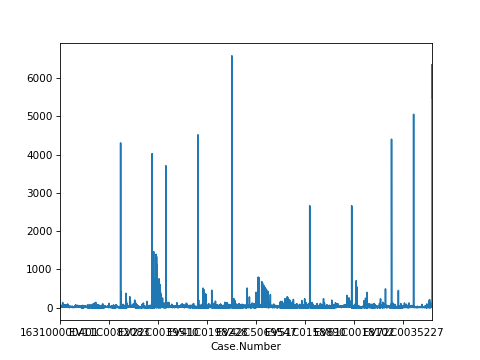

In [22]:
geocoded_df.loc[idx,'Case.Duration'].dt.days.plot()

In [23]:
pd.datetime(2016,6,2) - pd.datetime(2016,6,22)

datetime.timedelta(-20)

In [24]:
count_non_null(geocoded_df, 'Disposition.Date')

(68421, 207903)

In [25]:
count_non_null(geocoded_df, 'Disposition.Desc')

(68421, 207903)

In [26]:
count_non_null(geocoded_df, 'Judgment.In.Favor.Of')

(207525, 207903)

In [27]:
count_non_null(geocoded_df, 'Judgment.Against')

(207064, 207903)

In [28]:
set(geocoded_df['Judgment.Text'].str.lower())

{nan, 'agreed judgment', 'default judgment', 'final judgment'}

It would be useful to see who won each case. We can fuzzy match the in-favor-of with each of the plaintiff and defendants' names, and declare whichever is more similar the winner.

In [29]:
from fuzzywuzzy import fuzz

In [30]:
def pratio(x, y):
    if isinstance(x, float) or isinstance(y, float):
        return None
    return fuzz.ratio(x, y)

In [31]:
%%time
like_plaintiff = geocoded_df.apply(lambda x: pratio(x['Plaintiff.Name'], x['Judgment.In.Favor.Of']), axis=1)

like_defendant = geocoded_df.apply(lambda x: pratio(x['Defendant.Name'], x['Judgment.In.Favor.Of']), axis=1)

Wall time: 1min 19s


In [32]:
for_plaintiff = like_plaintiff > like_defendant
for_plaintiff.sum(), for_plaintiff.count()

(206036, 207903)

That seems high; let's look at a sample:

In [33]:
pd.DataFrame({'like_plaintiff': like_plaintiff.sample(100)}).join(pd.DataFrame({'like_defendant':like_defendant})).join(geocoded_df[['Plaintiff.Name','Defendant.Name','Judgment.In.Favor.Of']])

,like_plaintiff,like_defendant,Plaintiff.Name,Defendant.Name,Judgment.In.Favor.Of
Case.Number,,,,,
167100081564,100.0,32.0,Sterling Real Estate Group on Behalf of Patric...,Erica Marshall and/or All Occupants,Sterling Real Estate Group on Behalf of Patric...
168100022263,100.0,26.0,Park Hollow Apartments,"Hernandez, Joann",Park Hollow Apartments
175100153704,100.0,29.0,NXRTBH Old farm II LLC dba Old Farm Apartments,"Albudayri, Ahmed",NXRTBH Old farm II LLC dba Old Farm Apartments
175200029759,100.0,28.0,Trails of Ashford,"Morris, Gina",Trails of Ashford
178100006914,100.0,53.0,"Palacios, Leonor","Garcia, Lorena","Palacios, Leonor"
178200049053,100.0,25.0,Capital Estates the Vibe,"Randolph, Evelyn",Capital Estates the Vibe
EV11C0065029,100.0,27.0,Somerset I & II,"Townsend, Gina",Somerset I & II
EV11C0068883,100.0,28.0,"White, Lloyd A","Johnson, Alicia Lashon","White, Lloyd A"
EV11C0069694,100.0,26.0,"Fuentes, Matilde Mejia","Sacatenco, Rocio","Fuentes, Matilde Mejia"


That seems plausible; save this in a column

Which plaintiffs file the most eviction proceedings?

In [47]:
geocoded_df.groupby('Plaintiff.Name')['Plaintiff.Name'].count().sort_values(ascending=False).head(50)

Plaintiff.Name
Federal National Mortgage Association                               686
Federal Home Loan Mortgage Corporation                              604
Wyndham Park                                                        559
Pfirman, Richard L                                                  503
Villas at Pine Lake                                                 500
Federal National Mortgage Association A/K/A Fannie Mae              496
Crofton Place Apartments                                            491
Apartments of Cypress Houston Llc                                   473
Royal Phoenician Apartments                                         459
Green Tree Place                                                    453
Broadway Square Section 1                                           440
Lakewood Village Phase I Llc                                        420
Canfield Lakes                                                      413
The Reserve at 63 Sixty Three                    

In [34]:
geocoded_df['Judgment.In.Favor.Of.Plaintiff'] = for_plaintiff

CSV isn't great for mapping (also has no typed data); let's save this as a shapefile or geojson.

In [59]:
tmp_df = geocoded_df.copy()
tmp_df[[x for x in tmp_df.columns if x.endswith('Date')]] = tmp_df[[x for x in tmp_df.columns if x.endswith('Date')]].astype('str')
tmp_df['Judgment.Date'].head()

Case.Number
161100088444    2016-12-22
161100088460    2016-12-29
161100088468    2016-12-22
161100088487    2016-12-22
161100088489    2016-12-22
Name: Judgment.Date, dtype: object

In [100]:
tmp_df[tmp_df.columns[tmp_df.dtypes == 'category']] = tmp_df[tmp_df.columns[tmp_df.dtypes == 'category']].astype(str)
tmp_df['Judgment.In.Favor.Of.Plaintiff'] = tmp_df['Judgment.In.Favor.Of.Plaintiff'].astype(int)
tmp_df['Case.Duration'] = tmp_df['Case.Duration'].dt.days

In [101]:
tmp_df.to_file('geocoded_evictions.shp')

Next let's make a DF/file without explicit identifying information, since we don't need it for plotting/analysis.

In [104]:
tmp_df.columns.sort_values().values

array(['Attorney.Fees', 'Case.Duration', 'Case.File.Date', 'Case.Number.1',
       'Case.Status', 'Case.Subtype', 'Case.Type', 'Claim.Amount',
       'Court.Costs', 'Defendant.Addr.City', 'Defendant.Addr.Line.1',
       'Defendant.Addr.Line.2', 'Defendant.Addr.State',
       'Defendant.Addr.ZIP.1', 'Defendant.Atty.Addr.1',
       'Defendant.Atty.Addr.2', 'Defendant.Atty.City',
       'Defendant.Atty.Name', 'Defendant.Atty.State',
       'Defendant.Atty.ZIP.1', 'Defendant.Name', 'Disposition.Date',
       'Disposition.Desc', 'Exact', 'Geo.Address', 'Geo.Block',
       'Geo.FIPS.County', 'Geo.FIPS.State', 'Geo.Lon.Lat',
       'Geo.TIGER.LineID', 'Geo.TIGER.Side', 'Geo.Tract',
       'Judgment.Against', 'Judgment.Amount', 'Judgment.Date',
       'Judgment.In.Favor.Of', 'Judgment.In.Favor.Of.Plaintiff',
       'Judgment.Text', 'Nature.of.Claim', 'Next.Hearing.Date',
       'Next.Hearing.Desc', 'Next.Hearing.Time', 'Plaintiff.Addr.City',
       'Plaintiff.Addr.Line.1', 'Plaintiff.Addr.Line

In [128]:
cols=pd.Series(tmp_df.columns, index=tmp_df.columns)
tmp_df = tmp_df.drop(cols[cols.str.match(r'^(?:Second.)?(?:Defendant|Plaintiff)')], axis=1)
tmp_df = tmp_df.drop(['Case.Type', 'Case.Subtype', 'Nature.of.Claim','Judgment.Against','Judgment.In.Favor.Of',
                      'Next.Hearing.Date', 'Next.Hearing.Desc', 'Next.Hearing.Time', 'Style.Of.Case'
                     ], axis=1)

In [132]:
tmp_df.columns.sort_values()

Index(['Attorney.Fees', 'Case.Duration', 'Case.File.Date', 'Case.Number.1',
       'Case.Status', 'Claim.Amount', 'Court.Costs', 'Disposition.Date',
       'Disposition.Desc', 'Exact', 'Geo.Address', 'Geo.Block',
       'Geo.FIPS.County', 'Geo.FIPS.State', 'Geo.Lon.Lat', 'Geo.TIGER.LineID',
       'Geo.TIGER.Side', 'Geo.Tract', 'Judgment.Amount', 'Judgment.Date',
       'Judgment.In.Favor.Of.Plaintiff', 'Judgment.Text', 'Post-Judg.Int.Rate',
       'Pre-Judg.Int.Rate'],
      dtype='object')

In [133]:
tmp_df.sample(10)

,Case.Number.1,Case.File.Date,Claim.Amount,Case.Status,Disposition.Desc,Disposition.Date,Judgment.Text,Judgment.Date,Judgment.Amount,Attorney.Fees,...,Geo.Address,Geo.Lon.Lat,Geo.TIGER.LineID,Geo.TIGER.Side,Geo.FIPS.State,Geo.FIPS.County,Geo.Tract,Geo.Block,Case.Duration,Judgment.In.Favor.Of.Plaintiff
Case.Number,,,,,,,,,,,,,,,,,,,,,
EV42C5046011,EV42C5046011,2011-07-12,NaN,Disposed,NaN,NaT,Final Judgment,2011-08-16,0.0,0.0,...,"22727 NEWCOURT PLACE ST, TOMBALL, TX, 77375",POINT (-95.56780000000001 30.074547),627728135,R,48,201,554802,1020,0.0,1
EV21C0034464,EV21C0034464,2011-05-11,NaN,Disposed,Default Judgment (OCA),2011-05-23,Default Judgment,2011-05-23,2396.0,0.0,...,"5000 WATKINS WAY, FRIENDSWOOD, TX, 77546",POINT (-95.19186000000001 29.546553),96589034,L,48,201,350602,1036,0.0,1
175100158655,175100158655,2017-03-30,989.0,Disposed,NaN,NaT,Final Judgment,2017-04-19,0.0,0.0,...,"5515 DASHWOOD DR, HOUSTON, TX, 77081",POINT (-95.476715 29.707426),644742452,L,48,201,421500,2012,0.0,1
EV52C0376028,EV52C0376028,2016-03-17,NaN,Disposed,NaN,NaT,Default Judgment,2016-04-05,0.0,0.0,...,,None,,,,,,,0.0,1
EV12C0032099,EV12C0032099,2015-03-17,NaN,Disposed,NaN,NaT,Default Judgment,2015-04-01,560.0,0.0,...,"3813 WIPPRECHT ST, HOUSTON, TX, 77026",POINT (-95.32221 29.79431),96078632,L,48,201,211200,2004,0.0,1
EV41C0207106,EV41C0207106,2013-05-02,NaN,Appeal,Trial or Hearing by Judge (OCA),2013-05-21,Final Judgment,2013-05-21,290.0,0.0,...,"15915 KUYKENDAHL RD, HOUSTON, TX, 77068",POINT (-95.46386 30.00711),233443684,R,48,201,553002,1026,0.0,1
EV52C0315449,EV52C0315449,2011-08-24,NaN,Disposed,NaN,NaT,Default Judgment,2011-09-07,1620.0,0.0,...,"2400 BRIARWEST BLVD, HOUSTON, TX, 77077",POINT (-95.61411 29.739521),96618748,R,48,201,451402,2007,0.0,1
EV22C0050078,EV22C0050078,2016-04-20,NaN,Disposed,NaN,NaT,Final Judgment,2016-05-03,1444.0,0.0,...,"11810 ALGONQUIN DR, HOUSTON, TX, 77089",POINT (-95.19883 29.596191),96592290,R,48,201,350500,2006,0.0,1
EV31C0066331,EV31C0066331,2014-01-07,NaN,Disposed,Trial or Hearing by Judge (OCA),2014-01-22,Final Judgment,2014-01-22,0.0,0.0,...,"8906 TALTON ST, HOUSTON, TX, 77078",POINT (-95.25989 29.84392),96077983,R,48,201,231100,3007,0.0,1


In [134]:
col='Case.Status'
tmp_df.loc[tmp_df[col]=='null',col] = float('nan')

In [135]:
col='Case.Status'
set(tmp_df.loc[np.logical_not(tmp_df[col].isnull()),col])

{'Active', 'Appeal', 'Bankruptcy', 'Dismissed', 'Disposed'}

In [140]:
tmp_df = tmp_df.drop('Case.Number.1', axis=1)

In [142]:
tmp_df.reset_index().to_file('geocoded_evictions_deidentified.shp')

In [144]:
tmp_df.reset_index().to_file('geocoded_evictions_deidentified.geojson', driver='GeoJSON')

In [ ]:
tmp_df[np.logical_not(tmp_df['Geo.Lon.Lat'].isnull())].sample(5000).plot()

<IPython.core.display.Javascript object>